libraries

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import PolynomialFeatures

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import VotingClassifier
from vecstack import stacking
from scipy.stats.mstats import gmean

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
from sklearn.externals import joblib
import pickle
from itertools import combinations
import gc
from tqdm import tqdm
import platform

# Keras
import tensorflow as tf
# Tensorflow warning off
if tf.__version__[0] < '2':
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.constraints import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.preprocessing.image import *
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import *

from keras.models import Model, Sequential
from keras import Input
from keras import layers
from keras.optimizers import RMSprop
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


read data

In [3]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

transform data

##### high level: gds_grp_mclas_nm

In [17]:
train_test = pd.concat([df_train, df_test])

In [23]:
level =  'gds_grp_mclas_nm'
train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()


# max_len = 100

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
high (InputLayer)            (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 128)          6400      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 24,993
Trainable params: 24,993
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/70
2800/2800 [==============================] - 3s 1ms/step - loss: 0.6888 - acc: 0.5761 - val_loss: 0.6822 - val_acc: 0.6229
Epoch 2/70
2800/2800 [==============================] - 2s 891us/step - 

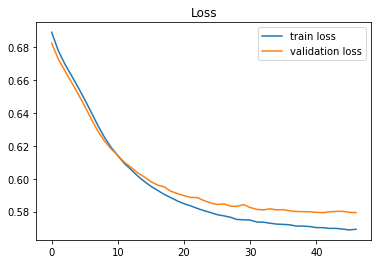

0.7356521059216012


In [51]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()


max_features = 50 # 대분류 nunique = 49
max_len = 100
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))

# max_len = 200

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
high (InputLayer)            (None, 200)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 200, 128)          6400      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 24,993
Trainable params: 24,993
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/70
2800/2800 [==============================] - 5s 2ms/step - loss: 0.6892 - acc: 0.5607 - val_loss: 0.6802 - val_acc: 0.6229
Epoch 2/70
2800/2800 [==============================] - 4s 2ms/step - lo

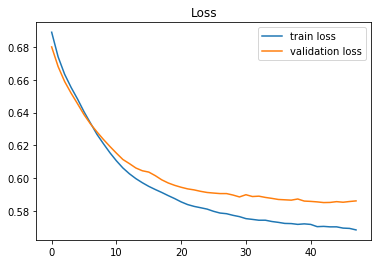

0.7319771684737282


In [53]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

max_features = 50 # 대분류 nunique = 49
max_len = 200
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))

# max_len = 300

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
high (InputLayer)            (None, 300)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 300, 128)          6400      
_________________________________________________________________
bidirectional_6 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 24,993
Trainable params: 24,993
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/70
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6854 - acc: 0.5850 - val_loss: 0.6739 - val_acc: 0.6229
Epoch 2/70
2800/2800 [==============================] - 7s 3ms/step - lo

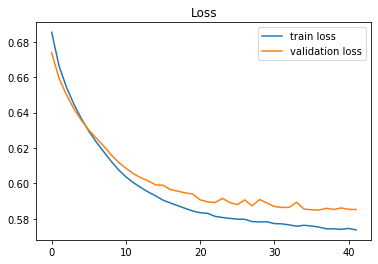

0.7298747219905477


In [54]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

max_features = 50 # 대분류 nunique = 49
max_len = 300
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))

# max_len = 400

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
high (InputLayer)            (None, 400)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 400, 128)          6400      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 24,993
Trainable params: 24,993
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/70
2800/2800 [==============================] - 11s 4ms/step - loss: 0.6837 - acc: 0.6050 - val_loss: 0.6743 - val_acc: 0.6229
Epoch 2/70
2800/2800 [==============================] - 10s 4ms/step - 

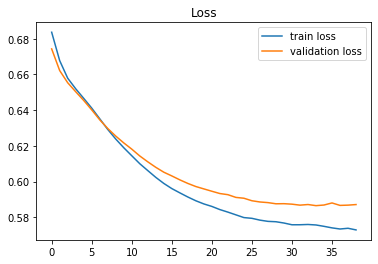

0.7294403322212955


In [55]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()


max_features = 50 # 대분류 nunique = 49
max_len = 400
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))

# max_len = 500

In [56]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()



max_features = 50 # 대분류 nunique = 49
max_len = 500
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
high (InputLayer)            (None, 500)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 500, 128)          6400      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 24,993
Trainable params: 24,993
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/70
2800/2800 [==============================] - 15s 5ms/step - loss: 0.6760 - acc: 0.6221 - val_loss: 0.6673 - val_acc: 0.6229
Epoch 2/70
2800/2800 [==============================] - 15s 5ms/step - 

KeyboardInterrupt: 

# max_len = 100 & oversample

In [59]:
seed= 2020

In [60]:
# oversample2: 
    # 1. unique X(get all products with duplication)
    # 2. replace=True(Restoration extraction)
    # 3. more buy, more oversample
    #       -> if you want to oversample in same ratio, just adjust n=1 to oversample=1, and erase 'for oversample in range(n)'

def oversample2(data, n=1, seed=seed):
    
    np.random.seed(seed)
    
    customerProducts = []
    
    for products in data:
        
        for oversample in range(n):
            
            products = list(np.append(products, np.random.choice(products, len(products) * oversample, replace=True)))
            
        customerProducts.append(products)
        
    return customerProducts

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
high (InputLayer)            (None, 100)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 100, 128)          6400      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 24,993
Trainable params: 24,993
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/70
2800/2800 [==============================] - 4s 1ms/step - loss: 0.6864 - acc: 0.6100 - val_loss: 0.6801 - val_acc: 0.6400
Epoch 2/70
2800/2800 [==============================] - 3s 1ms/step - lo

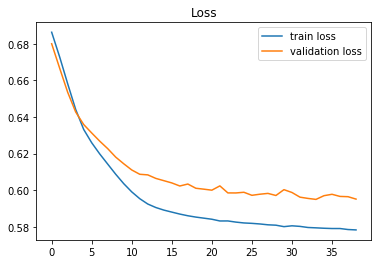

0.7147058312482624


In [61]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()



max_features = 50 # 대분류 nunique = 49
max_len = 100
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values


X_train = oversample2(X_train, 3)
X_test = oversample2(X_test, 3)



# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))

# max_len = 200 & oversample

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
high (InputLayer)            (None, 200)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 200, 128)          6400      
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 32)                18560     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 24,993
Trainable params: 24,993
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/70
2800/2800 [==============================] - 6s 2ms/step - loss: 0.6826 - acc: 0.6261 - val_loss: 0.6743 - val_acc: 0.6229
Epoch 2/70
2800/2800 [==============================] - 6s 2ms/step - l

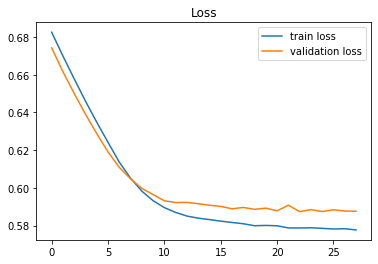

0.7284803308312483


In [62]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()



max_features = 50 # 대분류 nunique = 49
max_len = 200
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values


X_train = oversample2(X_train, 3)
X_test = oversample2(X_test, 3)



# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))

# max_len = 300 & oversample

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
high (InputLayer)            (None, 300)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 300, 128)          6400      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 32)                18560     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 24,993
Trainable params: 24,993
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/70
2800/2800 [==============================] - 9s 3ms/step - loss: 0.6877 - acc: 0.5789 - val_loss: 0.6796 - val_acc: 0.6229
Epoch 2/70
2800/2800 [==============================] - 9s 3ms/step - l

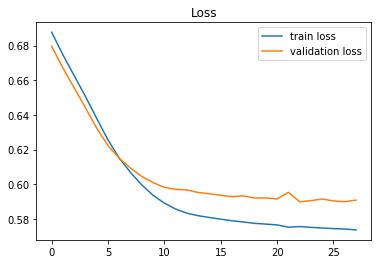

0.7221903669724771


In [63]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()



max_features = 50 # 대분류 nunique = 49
max_len = 300
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values


X_train = oversample2(X_train, 3)
X_test = oversample2(X_test, 3)



# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))

# max_len = 400 & oversample

In [ ]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()



max_features = 50 # 대분류 nunique = 49
max_len = 400
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values


X_train = oversample2(X_train, 3)
X_test = oversample2(X_test, 3)



# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))

# max_len = 500 & oversample

In [ ]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()



max_features = 50 # 대분류 nunique = 49
max_len = 500
emb_dim = 128


# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values


X_train = oversample2(X_train, 3)
X_test = oversample2(X_test, 3)



# Pads sequences to the same length
X_train_high = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_test_high = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

X_train_high.shape, X_test_high.shape

i = int(round(X_train_high.shape[0] * 0.8, 0))
X_valid, y_valid = X_train_high[i:], y_train[i:]
X_train, y_train = X_train_high[:i], y_train[:i]

# Define the Model & its Architecture
# in_low = Input(shape=(max_len,), dtype='int32', name='low')
# x = Embedding(max_features, emb_dim)(in_low)
# out_low = Bidirectional(LSTM(16))(x)

# in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
# x = Embedding(max_features//10, emb_dim)(in_mid)
# out_mid = Bidirectional(LSTM(16))(x)

# in_high = Input(shape=(max_len,), dtype='int32', name='high')
# x = Embedding(max_features//100, emb_dim)(in_high)
# out_high = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len, ), dtype='int32', name='high')
x = Embedding(max_features, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)


x = out_high
out = Dense(1, activation='sigmoid')(x)

model = Model(in_high, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=64, 
                    validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()



print(roc_auc_score(y_valid, model.predict(X_valid)))